In [20]:
import pathlib

import matplotlib as mpl
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

%matplotlib inline
%run ../../scripts/plotting_helper.py
from matplotlib import pyplot as plt

savefig_args = {
    "dpi": 300,
    "bbox_inches": "tight",
    "pad_inches": 0,
    "transparent": True,
}
output_dir = "../../figures/figure1"
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
output_suffix = ""
output_formats = [".svg", ".png",".eps"]
filetype = "pdf"
sc.settings.figdir = output_dir
sc.set_figure_params(format=filetype, transparent=True)
sc.set_figure_params(dpi_save=600, figsize=(5, 5))


def save_figure(
    fig,
    name,
    output_dir=output_dir,
    output_suffix=output_suffix,
    output_formats=output_formats,
    savefig_args=savefig_args,
):
    for output_format in output_formats:
        fig.savefig(
            output_dir + "/" + name + output_suffix + output_format, **savefig_args
        )
    return None


pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)

plt.style.use("../../scripts/paper_umap.mplstyle")
width = plt.rcParams["figure.figsize"][0]
height = plt.rcParams["figure.figsize"][1]

<Figure size 432x288 with 0 Axes>


# 1B UMAPs of Annotations

In [2]:
# Just the B Cells instead:
bcells = sc.read_h5ad("../../processed_data/h5ad_objects/bcells.h5ad")

# Cell type Annotations

In [4]:
bcells.obs.sample_id.value_counts()

Day 0        15881
Day 4         8553
BM CD138+     4685
Day 8         2105
PBMC          1245
Day 12         819
BMMNC          642
Name: sample_id, dtype: int64

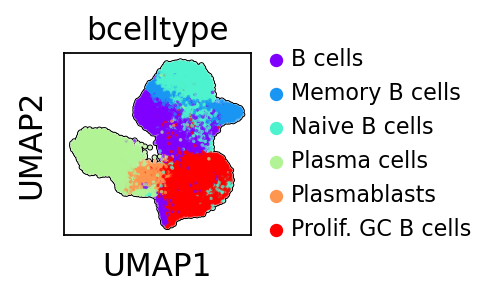

In [5]:
adata = bcells
color = "bcelltype"
palette = bcelltype_colors
sc.pl.umap(
    adata,
    color=color,
    palette=palette,
    size=10,
    add_outline=True,
    save="_{}.{}".format(color, filetype),
)

(30791, 172)


/home/michaelswift/miniconda3/envs/muon/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


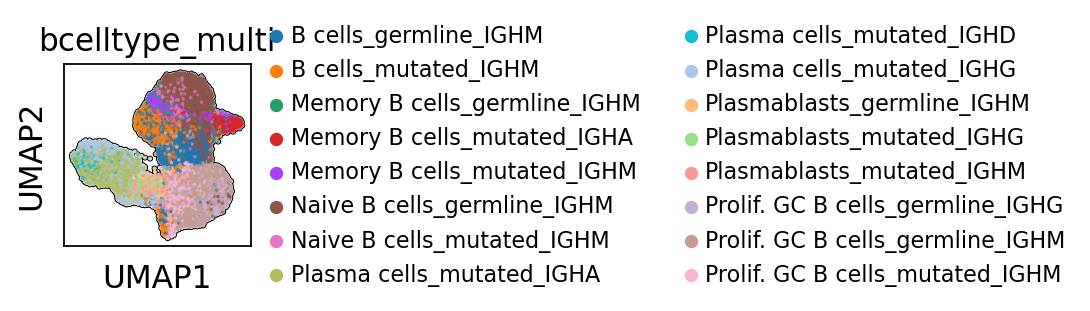

In [6]:
adata = bcells
# filter out very low abundance cells
filter_low_abundance_celltypes = True
if filter_low_abundance_celltypes:
    select = adata.obs.bcelltype_multi.value_counts() > (adata.obs.shape[0] / 100)
    adata = adata[adata.obs.bcelltype_multi.isin(select[select == True].index)]
    print(adata.obs.shape)
color = "bcelltype_multi"
#palette = bcelltype_colors
sc.pl.umap(
    adata,
    color=color,
    #palette=palette,
    size=10,
    add_outline=True,
    save="_{}.{}".format(color, filetype),
)

# Sample Annotations

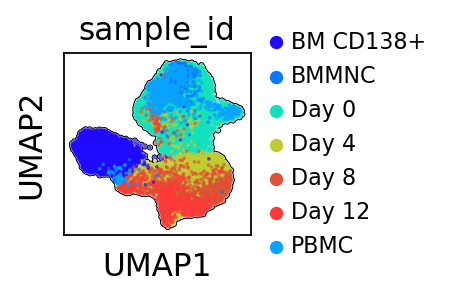

In [7]:
color = "sample_id"
palette = sample_id_colors
sc.pl.umap(
    adata,
    color=color,
    size=10,
    palette=palette,
    add_outline=True,
    save="_{}.{}".format(color, filetype),
)

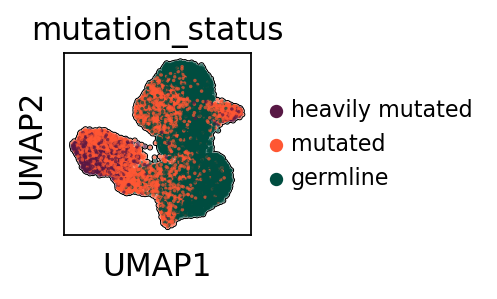

In [8]:
color = "mutation_status"
palette = mutation_colors
sc.pl.umap(
    adata,
    color=color,
    size=10,
    palette=palette,
    add_outline=True,
    save="_{}.{}".format(color, filetype),
)

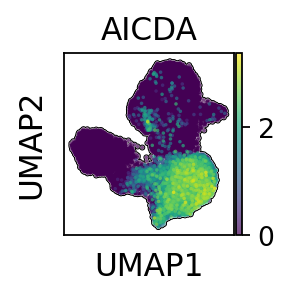

In [9]:
color = "AICDA"

sc.pl.umap(
    adata,
    color=color,
    size=10,
    add_outline=True,
    save="_{}.{}".format(color, filetype),
)

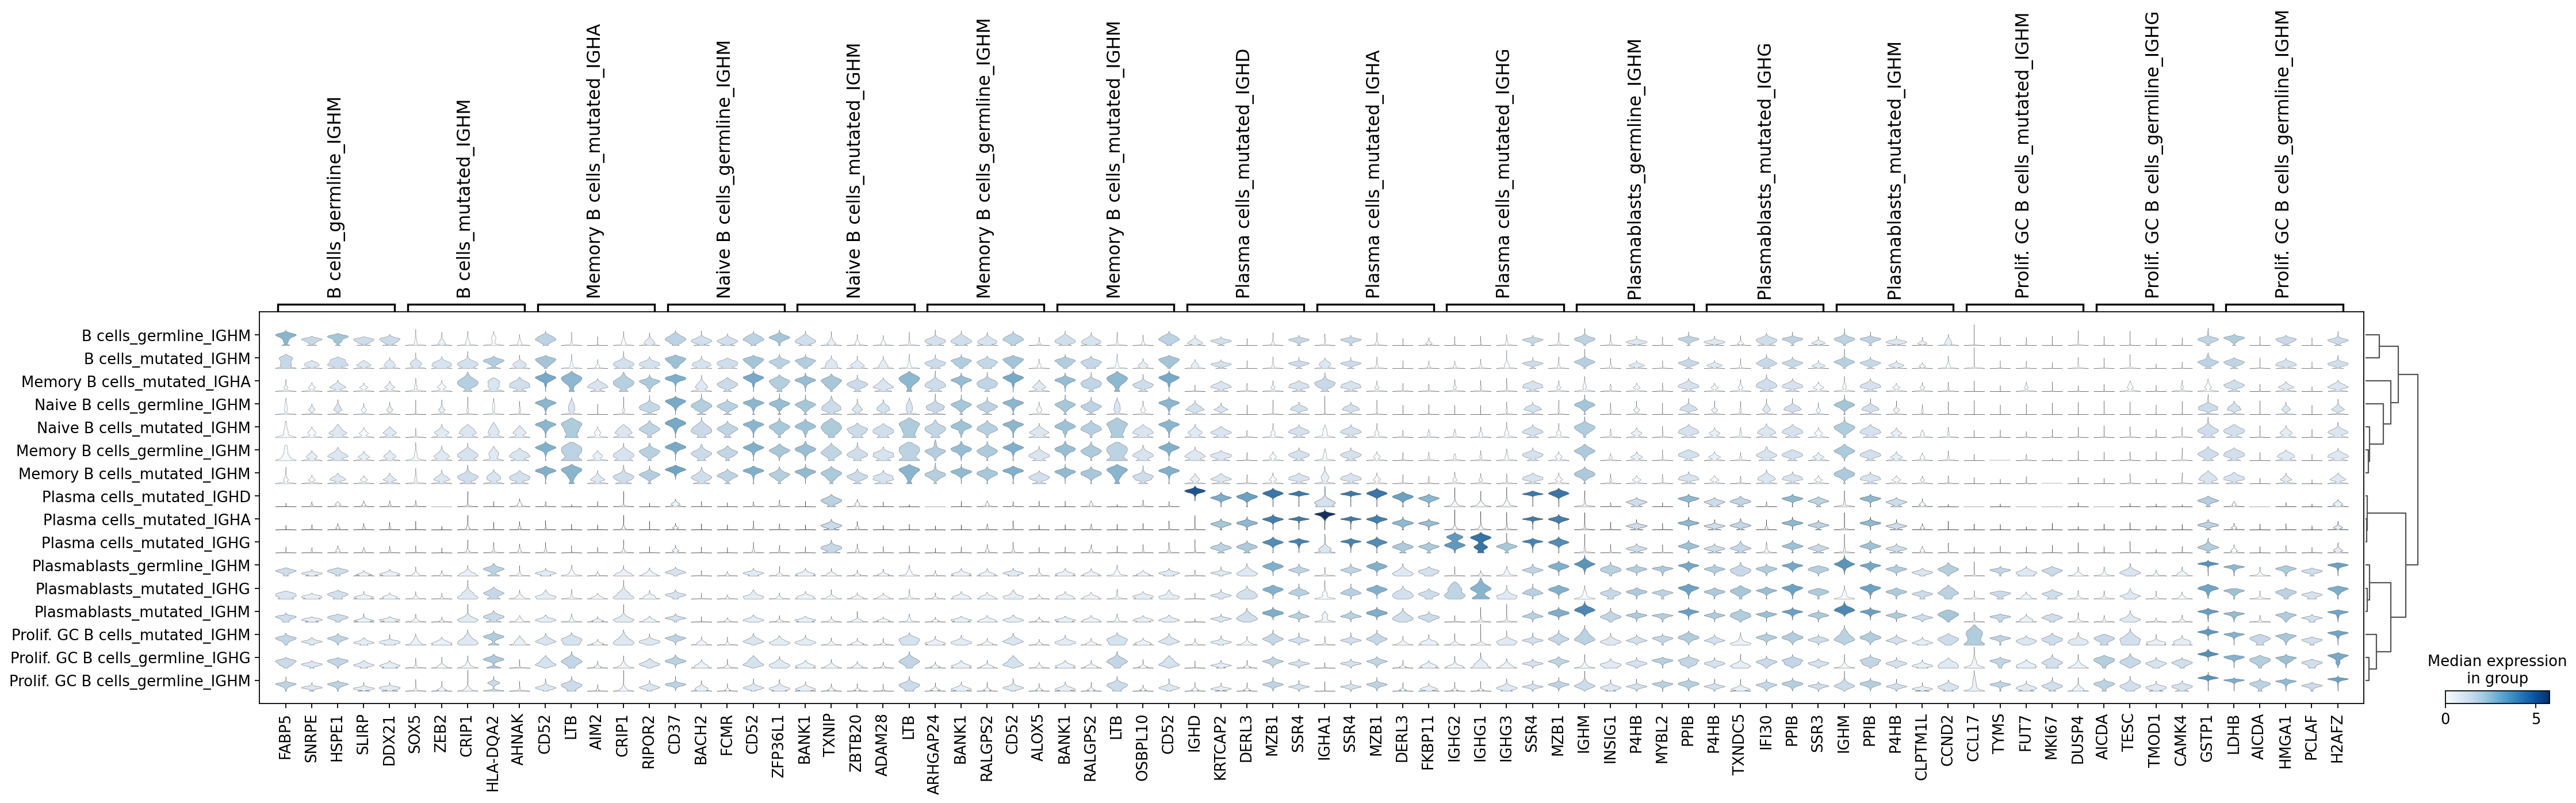

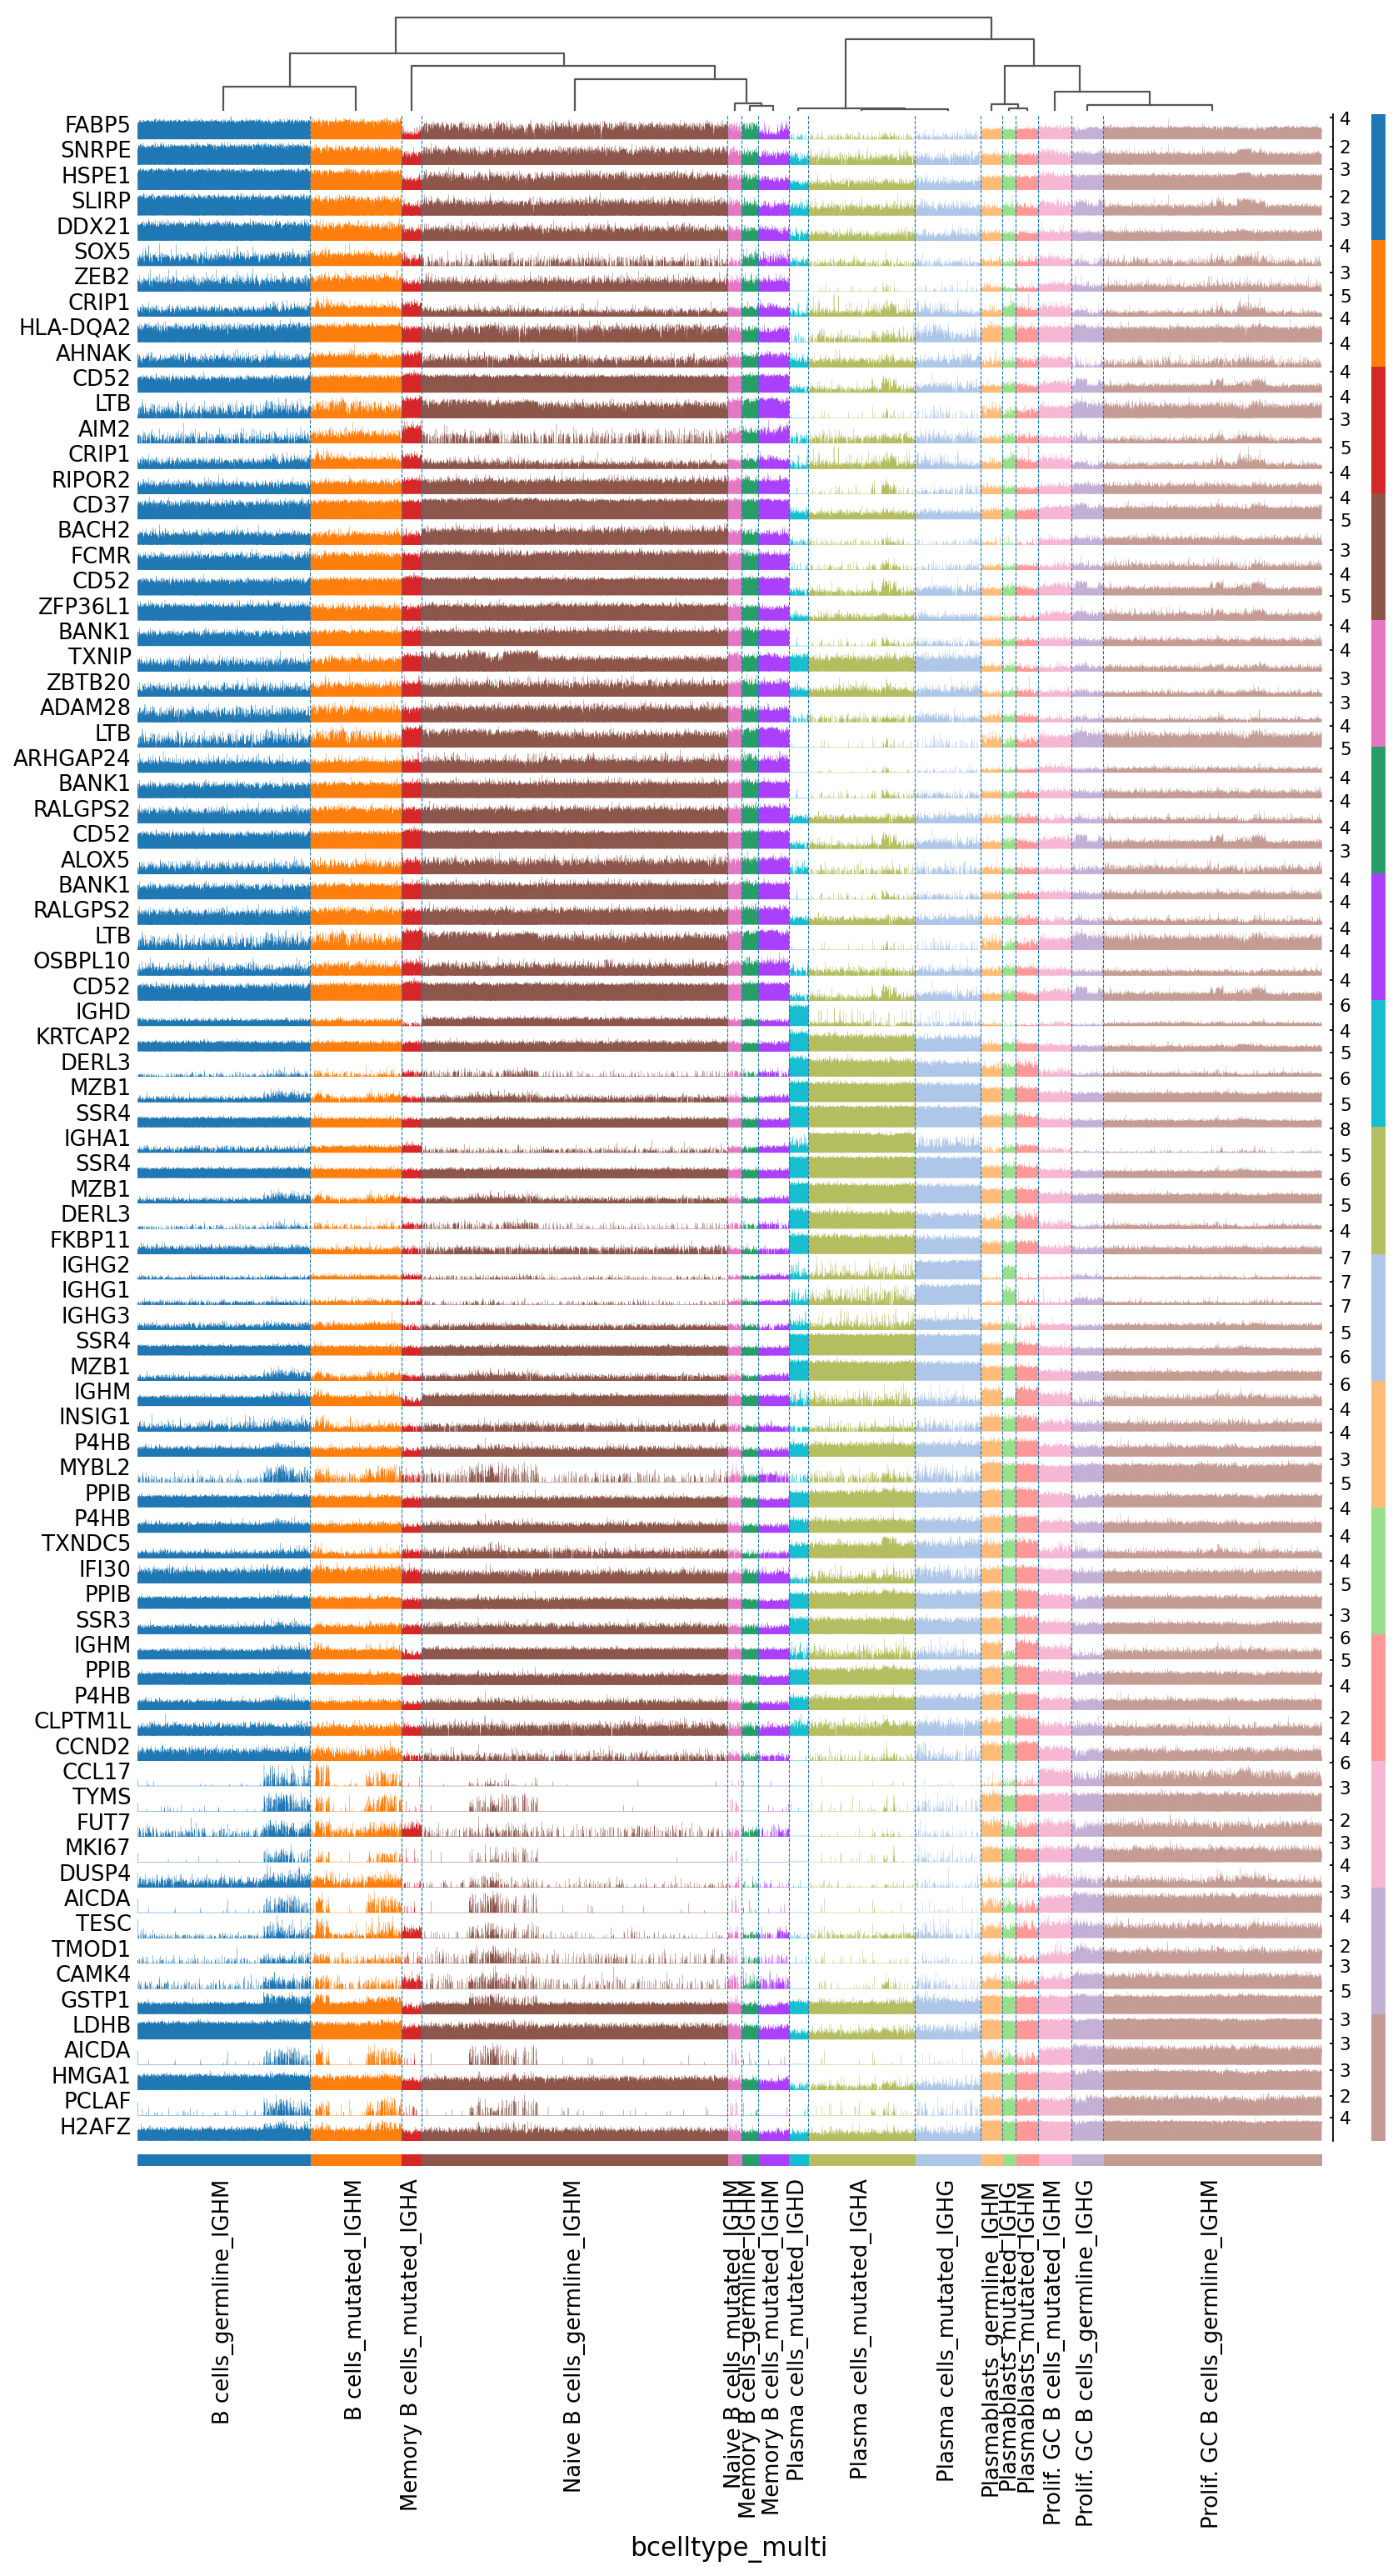

In [10]:
label = "bcelltype_multi"

sc.tl.rank_genes_groups(adata, groupby=label, method="wilcoxon")

sc.pl.rank_genes_groups_stacked_violin(
    adata, min_logfoldchange=1.5, n_genes=5, save="complex_bcelltype.svg"
)
sc.pl.rank_genes_groups_tracksplot(
    adata, min_logfoldchange=1.5, n_genes=5, save="complex_bcelltype.svg"
)

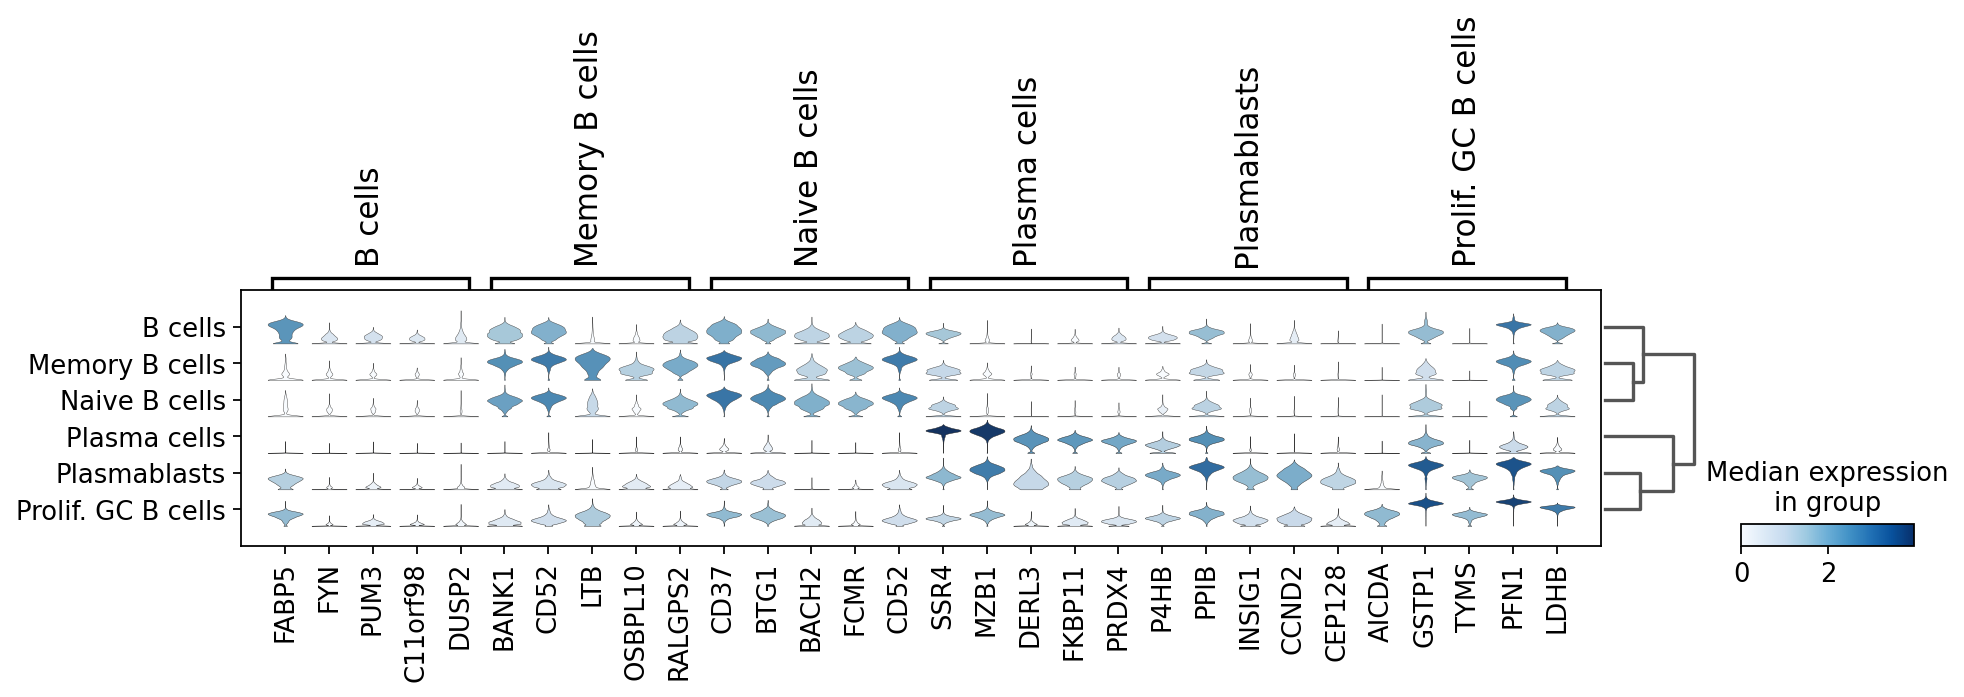

In [16]:
label = "bcelltype"
sc.settings.figdir = output_dir
sc.set_figure_params(format=filetype, transparent=True)
sc.set_figure_params(dpi_save=300, figsize=(5, 5))
sc.tl.rank_genes_groups(adata, groupby="bcelltype", method="wilcoxon")
sc.pl.rank_genes_groups_stacked_violin(
    adata, min_logfoldchange=1.5, n_genes=5, save="{}.svg".format(label)
)

# Plot Proportions of Cell Types Generated

In [17]:
plt.style.use("../../scripts/paper.mplstyle")

In [18]:
plot_order

['10X_BMMNC', '10X_PBMC', 'BM CD138+', 'Day 0', 'Day 4', 'Day 8', 'Day 12']

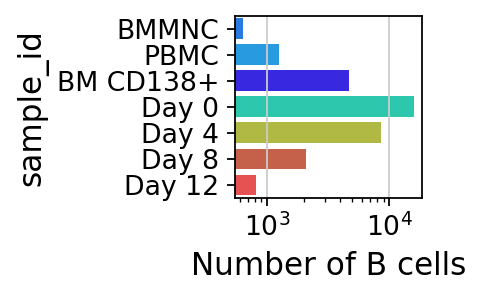

In [22]:
adata = bcells
group = "sample_id"
palette = sample_id_colors
order = plot_order
data = adata.obs

fig, ax = plt.subplots(1, 1, figsize=(width, height))
g = sns.countplot(y="sample_id", data=data, order=order, palette=palette)
plt.xscale("log")
#plt.xticks([0,10,100,1000, 10000])
plt.xlabel("Number of B cells")

save_figure(fig, "number_of_cells_{}".format(group))

# 1C

Text(0, 0.5, 'sample_id')

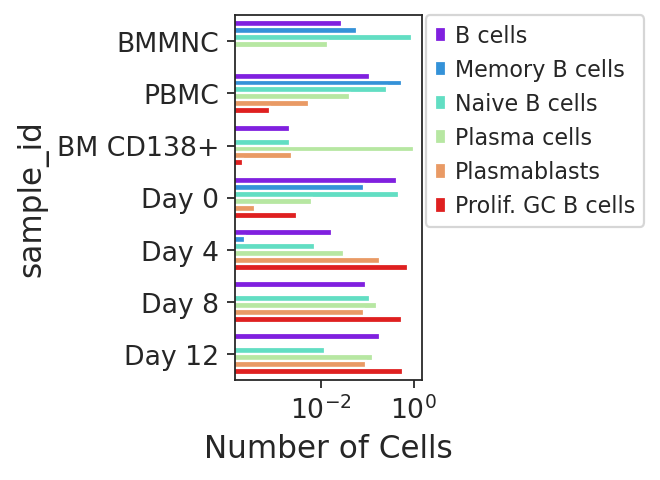

In [23]:
group = "sample_id"
label = "bcelltype"
color = label
palette = bcelltype_colors
data = pd.DataFrame(adata.obs.groupby([group])[label].value_counts(normalize=True))
data.columns = ["dummy"]
data.reset_index(inplace=True)
data.columns = ["sample_id", "celltype", "proportion"]
sns.axes_style("white")
sns.set_style("ticks")
fig, ax = plt.subplots(1, 1, figsize=(width, height * 2))

sns.barplot(
    y="sample_id",
    x="proportion",
    hue="celltype",
    palette=palette,
    data=data,
    order=order,
)

plt.xscale("log")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.xlabel("Number of Cells")
plt.ylabel("sample_id")

# 1C

In [26]:
group = "sample_id"
label = "bcelltype"
nboots = 1000
hold_stats = []
data = adata.obs
for i in range(nboots):
    bootstrap = data.groupby(group).sample(frac=1, replace=True)
    stats = pd.DataFrame(bootstrap.groupby(group)[label].value_counts(normalize=True))
    stats.columns = ["proportion"]
    hold_stats.append(stats)
data = pd.concat(hold_stats)

data.reset_index(inplace=True)
data.columns = ["sample_id", "celltype", "proportion"]

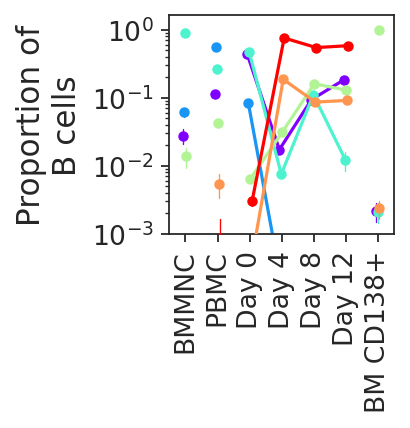

In [27]:
group = "sample_id"
label = "celltype"
order = ['BMMNC', 'PBMC', 'Day 0', 'Day 4', 'Day 8', 'Day 12', 'BM CD138+']
palette = bcelltype_colors
sns.set_style("ticks")
fig, ax = plt.subplots(1, 1, figsize=(width * 1.2, height * 1.2))
data1 = data[data[group].str.contains("Day")]
data2 = data[~data[group].str.contains("Day")]
ax = sns.pointplot(
    x=group,
    y="proportion",
    hue=label,
    capsize=0,
    scale=0.8,
    palette=palette,
    data=data1,
    join=True,
    ci="sd",
    errwidth=0.6,
    order=order,
    dodge=True,
)

ax = sns.pointplot(
    x=group,
    y="proportion",
    hue=label,
    capsize=0,
    scale=0.8,
    data=data2,
    join=False,
    palette=palette,
    ci="sd",
    errwidth=0.6,
    order=order,
    dodge=True,
)
plt.yscale("log")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
locs, labels = plt.xticks()
plt.ylim(0.001)
plt.ylabel("Proportion of\nB cells")
plt.setp(labels, rotation=90)
plt.xlabel('')
# remove legend
ax.get_legend().remove()

In [28]:
save_figure(fig, "Proportion_PointPlot_bcelltype")

## Extra Figures for Poster

In [29]:
sub_adata = adata[adata.obs.sample_id.str.contains('Day')]

In [31]:
sub_adata.obs['Input_Output'] = sub_adata.obs.sample_id == 'Day 0'
sub_adata.obs.Input_Output = sub_adata.obs.Input_Output.astype(str)
sub_adata.obs.Input_Output = sub_adata.obs.Input_Output.str.replace("True", "Input Population")
sub_adata.obs.Input_Output = sub_adata.obs.Input_Output.str.replace("False", "Output Population")

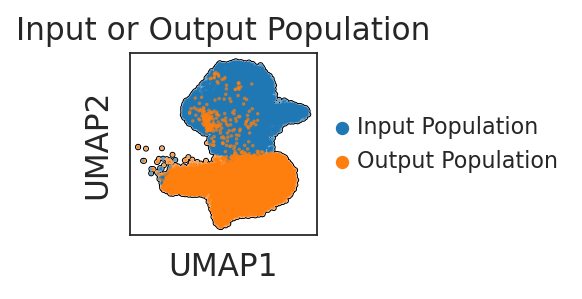

In [32]:
adata = sub_adata
color = "Input_Output"
sc.pl.umap(
    adata,
    color=color,
    size=10,
    add_outline=True,
    title = "Input or Output Population",
    save="_{}.{}".format(color, filetype),
)

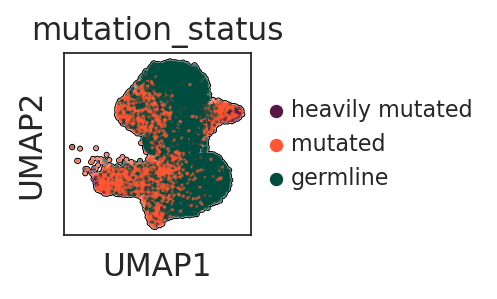

In [33]:
adata = sub_adata
color = "mutation_status"
palette = mutation_colors
sc.pl.umap(
    adata,
    color=color,
    palette=palette,
    size=10,
    add_outline=True,
    save="timecourse_{}.{}".format(color, filetype),
)

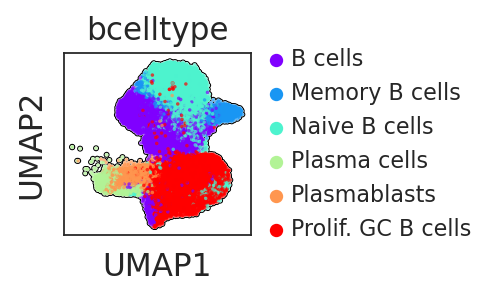

In [34]:
adata = sub_adata
color = "bcelltype"
palette = bcelltype_colors
sc.pl.umap(
    adata,
    color=color,
    palette=palette,
    size=10,
    add_outline=True,
    save="timecourse_{}.{}".format(color, filetype),
)